In [54]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

sns.set_theme(style="whitegrid")

%matplotlib inline
DATA_FOLDER = 'data/'
training_filename = 'training.csv'

In [55]:
df = pd.read_csv(DATA_FOLDER + training_filename)
df.head()

,id_policy,year,pol_no_claims_discount,pol_coverage,pol_duration,pol_sit_duration,pol_pay_freq,pol_payd,pol_usage,drv_sex1,...,vh_make_model,vh_age,vh_fuel,vh_type,vh_speed,vh_value,vh_weight,population,town_surface_area,claim_amount
0,PL000000,1.0,0.332,Med2,5,1,Monthly,No,WorkPrivate,M,...,aparvvfowrjncdhp,8.0,Gasoline,Tourism,174.0,11040.0,1143.0,1270.0,33.1,0.0
1,PL042495,1.0,0.000,Med2,6,1,Monthly,No,WorkPrivate,M,...,aparvvfowrjncdhp,10.0,Diesel,Tourism,174.0,11040.0,1143.0,1290.0,51.3,0.0
2,PL042496,1.0,0.196,Med1,2,1,Yearly,Yes,Retired,M,...,iwhqpdfuhrsxyqxe,8.0,Diesel,Commercial,150.0,14159.0,1193.0,1020.0,262.8,0.0
3,PL042497,1.0,0.000,Med2,8,5,Yearly,No,WorkPrivate,F,...,kvcddisqpkysmvvo,4.0,Gasoline,Tourism,149.0,17233.0,1012.0,180.0,219.7,0.0
4,PL042498,1.0,0.000,Med1,2,2,Yearly,No,Retired,F,...,tdgkjlphosocwbgu,13.0,Gasoline,Tourism,200.0,19422.0,1315.0,30.0,70.3,0.0


In [56]:
def one_hot_encode_all(df, columns):
    for entry in columns:
        temp = pd.get_dummies(df[entry], prefix=entry)
        df = pd.concat([df, temp], axis=1).drop(entry,axis=1)
    return df

def dummy_encode_all(df, master_mapper):
    for colname, array in master_mapper.items():
        mapper = {v:k for k,v in enumerate(array)}
        for entry in mapper:
            df[colname] = df[colname].replace(entry,mapper[entry])        
    return df


In [57]:
y_colname = 'claims_amount'
X_col_names = [x for x in df.columns if x != y_colname]

### Find Feature Importance on whether someone claims or not

In [58]:
categorical = df.dtypes[df.dtypes == 'object']
non_categorical = df.dtypes[df.dtypes != 'object']

In [59]:
ID_col = 'id_policy'
ordinal_vars = {'pol_coverage':['Min','Med1','Med2','Max'],
               'pol_pay_freq':["Quarterly","Monthly",'Yearly','Biannual']}
categorical_vars = [x for x in categorical.index if x not in ordinal_vars and x != ID_col]


In [60]:
X = df[X_col_names].drop(['year','pol_no_claims_discount'],axis=1)
claimed = df[df['claim_amount'] > 0]['id_policy'].unique()

In [61]:
X = X.drop_duplicates('id_policy','last').reset_index(drop=True)
y = X['id_policy'].isin(claimed).reset_index(drop=True)
X.head()

,id_policy,pol_coverage,pol_duration,pol_sit_duration,pol_pay_freq,pol_payd,pol_usage,drv_sex1,drv_age1,drv_age_lic1,...,vh_make_model,vh_age,vh_fuel,vh_type,vh_speed,vh_value,vh_weight,population,town_surface_area,claim_amount
0,PL005608,Med2,7,6,Biannual,No,WorkPrivate,M,57.0,39.0,...,gapclpflkdsbeorm,16.0,Diesel,Commercial,150.0,25662.0,1780.0,330.0,38.7,0.0
1,PL082834,Max,29,13,Yearly,No,Retired,M,84.0,62.0,...,aparvvfowrjncdhp,16.0,Diesel,Tourism,174.0,11040.0,1143.0,80.0,111.7,0.0
2,PL095626,Max,12,7,Yearly,No,WorkPrivate,F,55.0,26.0,...,iulvirmzdntweaee,13.0,Gasoline,Tourism,164.0,14696.0,936.0,30.0,138.6,0.0
3,PL085678,Med2,17,8,Biannual,No,WorkPrivate,M,46.0,22.0,...,iulvirmzdntweaee,18.0,Diesel,Tourism,164.0,14696.0,936.0,1020.0,359.4,0.0
4,PL067999,Max,17,4,Monthly,No,WorkPrivate,M,48.0,26.0,...,jjycmklnkdivnypu,4.0,Gasoline,Tourism,174.0,13904.0,1260.0,280.0,745.4,0.0


In [62]:
X = dummy_encode_all(X,ordinal_vars)
X.corr()

,pol_coverage,pol_duration,pol_sit_duration,pol_pay_freq,drv_age1,drv_age_lic1,drv_age2,drv_age_lic2,vh_age,vh_speed,vh_value,vh_weight,population,town_surface_area,claim_amount
pol_coverage,1.000000,0.116141,-0.074296,0.013260,0.056515,0.058328,0.070075,0.073693,-0.547224,0.246547,0.092552,0.164011,0.029743,-0.012400,0.056059
pol_duration,0.116141,1.000000,0.279050,0.179902,0.378343,0.360899,0.114985,0.102633,0.011393,-0.003650,-0.068595,-0.014499,0.011805,0.025933,0.002839
pol_sit_duration,-0.074296,0.279050,1.000000,0.106963,0.246074,0.214103,0.164940,0.146161,0.281282,-0.097429,-0.097573,-0.088544,0.009165,0.006833,-0.019881
pol_pay_freq,0.013260,0.179902,0.106963,1.000000,0.205880,0.203713,0.099906,0.095709,0.005755,-0.007005,0.007731,-0.001462,0.006406,-0.012604,-0.003372
drv_age1,0.056515,0.378343,0.246074,0.205880,1.000000,0.923206,0.544617,0.493636,0.062028,-0.022826,-0.042254,-0.029230,0.016832,0.029888,0.000869
drv_age_lic1,0.058328,0.360899,0.214103,0.203713,0.923206,1.000000,0.489253,0.454796,0.041095,-0.015392,-0.006003,-0.002258,0.004579,0.031966,0.001712
drv_age2,0.070075,0.114985,0.164940,0.099906,0.544617,0.489253,1.000000,0.939736,-0.034847,0.048219,0.038192,0.038358,-0.008055,0.021818,0.003603
drv_age_lic2,0.073693,0.102633,0.146161,0.095709,0.493636,0.454796,0.939736,1.000000,-0.042544,0.036703,0.031785,0.029835,-0.014964,0.029204,-0.000801
vh_age,-0.547224,0.011393,0.281282,0.005755,0.062028,0.041095,-0.034847,-0.042544,1.000000,-0.180972,-0.095859,-0.129702,-0.026764,0.023277,-0.056382
vh_speed,0.246547,-0.003650,-0.097429,-0.007005,-0.022826,-0.015392,0.048219,0.036703,-0.180972,1.000000,0.492068,0.566290,0.026426,-0.030528,0.027821


In [63]:
X = one_hot_encode_all(X,categorical_vars)
X

,id_policy,pol_coverage,pol_duration,pol_sit_duration,pol_pay_freq,drv_age1,drv_age_lic1,drv_age2,drv_age_lic2,vh_age,...,vh_make_model_zycfmwxhaaaxdwpb,vh_make_model_zydfvjqmmwhyfuyy,vh_make_model_zzjxvhegwmgqodzk,vh_make_model_zzlzzujtugbfpsvv,vh_make_model_zzubfikjmmfsxhbn,vh_fuel_Diesel,vh_fuel_Gasoline,vh_fuel_Hybrid,vh_type_Commercial,vh_type_Tourism
0,PL005608,2,7,6,3,57.0,39.0,NaN,NaN,16.0,...,0,0,0,0,0,1,0,0,1,0
1,PL082834,3,29,13,2,84.0,62.0,NaN,NaN,16.0,...,0,0,0,0,0,1,0,0,0,1
2,PL095626,3,12,7,2,55.0,26.0,NaN,NaN,13.0,...,0,0,0,0,0,0,1,0,0,1
3,PL085678,2,17,8,3,46.0,22.0,57.0,38.0,18.0,...,0,0,0,0,0,1,0,0,0,1
4,PL067999,3,17,4,1,48.0,26.0,NaN,NaN,4.0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57049,PL008818,2,4,4,1,50.0,28.0,23.0,5.0,15.0,...,0,0,0,0,0,1,0,0,0,1
57050,PL055033,3,14,5,1,40.0,22.0,34.0,12.0,5.0,...,0,0,0,0,0,1,0,0,0,1
57051,PL061619,3,10,4,2,71.0,37.0,NaN,NaN,15.0,...,0,0,0,0,0,0,1,0,0,1
57052,PL060903,3,25,15,3,49.0,31.0,NaN,NaN,31.0,...,0,0,0,0,0,1,0,0,0,1


In [64]:
clf = xgb.XGBClassifier(n_estimators=300)
X_without_id = X.drop(['id_policy','claim_amount'],axis=1)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_without_id,y, test_size=0.2)

In [66]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [67]:
preds = clf.predict(X_test)

In [68]:
confusion_matrix(y_test,preds)

array([[6795,  909],
       [2957,  750]])

In [69]:
imp = clf.get_booster().get_score(importance_type="gain")

In [71]:
imp_df = pd.DataFrame([[x,imp[x]] for x in imp]).sort_values(1,ascending=False).head(20)

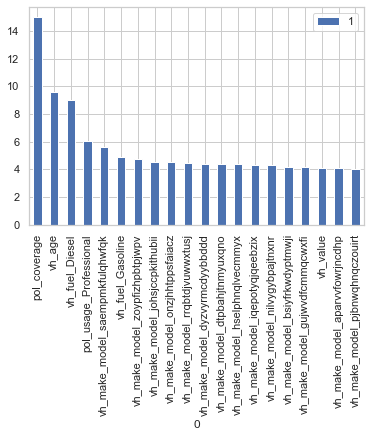

In [70]:
imp_df.plot(x=0,y=1,kind='bar')